In [1]:
# imports
import numpy as np
np.random.seed(42)
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.applications import ConvNeXtTiny

# Neural Network

Here we build a basic neural network to classify out images. The below code repurposed many aspects of previous projects I worked on with colleagues. Most of the neural network and metrics takes inspiration from [A plant disease classification project](https://github.com/DerikVo/DSI_project_4_plant_disease) and a single day [Hack-a-thon](https://github.com/DerikVo/NN_hackathon) to classify if an object was a hotdog or not a hotdog.

In [2]:
# set the training and testing paths
training_folder_path = '../Images/Training'
testing_folder_path = '../Images/Testing'

In [3]:
# manually list out the class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
datagen = ImageDataGenerator(validation_split=0.30)
# Get the training data
train_ds = datagen.flow_from_directory(
    training_folder_path,
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=32,
    classes=class_names,
    class_mode='categorical',
    subset='training',  # Set as training data
    seed=42
)

# Get the validation data
val_ds = datagen.flow_from_directory(
    training_folder_path,
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=32,
    classes=class_names,
    class_mode='categorical',
    subset='validation',  # Set as validation data
    seed=42,
    shuffle=False
)

# Get the test data
test_ds = datagen.flow_from_directory(
    testing_folder_path,
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    seed=42,
    shuffle=False
)


Found 4000 images belonging to 4 classes.
Found 1712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## First model
This model uses many aspects of a prior project for [plant disease classification](https://github.com/DerikVo/DSI_project_4_plant_disease/tree/main)

In [5]:
early_stopping = EarlyStopping(patience=5)

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 53s 397ms/step - loss: 6.8160 - accuracy: 0.7832 - val_loss: 0.9318 - val_accuracy: 0.7576
Epoch 2/10
125/125 [==============================] - 42s 338ms/step - loss: 0.1863 - accuracy: 0.9375 - val_loss: 1.1293 - val_accuracy: 0.7535
Epoch 3/10
125/125 [==============================] - 42s 335ms/step - loss: 0.1109 - accuracy: 0.9645 - val_loss: 1.5578 - val_accuracy: 0.7500
Epoch 4/10
125/125 [==============================] - 44s 348ms/step - loss: 0.0502 - accuracy: 0.9835 - val_loss: 1.4596 - val_accuracy: 0.7407
Epoch 5/10
125/125 [==============================] - 42s 333ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 2.4034 - val_accuracy: 0.7640
Epoch 6/10
125/125 [==============================] - 42s 339ms/step - loss: 0.0518 - accuracy: 0.9847 - val_loss: 2.0532 - val_accuracy: 0.7319


In [9]:
model.save('../Models/CNN_base.h5')

### Interpretation:
Here we see that our training accuracy is about 98% while our validation is 73% which suggest our model is very overfit. We will need to either reduce features or add some regularization. Lets try adding some regularization to our next model.

## Second model
This model uses regularization to try to combat overfiting. The model uses techniques learned from the [General Assembly Data science immersive bootcamp](https://generalassemb.ly/education/data-science) which taught a lab on regularization with convolutional neural networks.

In [11]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.5))

model2.add(Dense(4, activation='softmax'))

In [12]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 48s 379ms/step - loss: 18.2575 - accuracy: 0.6522 - val_loss: 6.2715 - val_accuracy: 0.6016
Epoch 2/10
125/125 [==============================] - 46s 368ms/step - loss: 5.0119 - accuracy: 0.8335 - val_loss: 4.9253 - val_accuracy: 0.7062
Epoch 3/10
125/125 [==============================] - 46s 369ms/step - loss: 4.0644 - accuracy: 0.8440 - val_loss: 4.1530 - val_accuracy: 0.7424
Epoch 4/10
125/125 [==============================] - 47s 372ms/step - loss: 3.2763 - accuracy: 0.8925 - val_loss: 3.7652 - val_accuracy: 0.7290
Epoch 5/10
125/125 [==============================] - 46s 366ms/step - loss: 2.8264 - accuracy: 0.8947 - val_loss: 3.3068 - val_accuracy: 0.7296
Epoch 6/10
125/125 [==============================] - 47s 375ms/step - loss: 2.4847 - accuracy: 0.8972 - val_loss: 2.9961 - val_accuracy: 0.7307
Epoch 7/10
125/125 [==============================] - 47s 378ms/step - loss: 2.1203 - accuracy: 0.9120 - val_loss: 2.6917 - val_a

In [14]:
model2.save('../Models/CNN_regularization.h5')

### Interpretation:
Here we see that our training accuracy is about 91% while our validation is 74% which suggest our model is still overfit, but not as much. 

Since our validation score was higher without regularization we will stick with the first model. Augmentation was attempted but there was a memory issue. It wasn't till later that I realized I could have saved the images and read in those images instead of having it in my active memory. With that being said we also want to know how the model performs using other metrics such as precision, recall, and F1.

# Measuring metrics

In [15]:
import sys
sys.path.append('../modules/')
import model as m
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [16]:
'''
Code is based on previous projects:
This code is based on code provided by CHAT GPT with two different prompts. Both prompts can be found in the model.py file
THe code was adapted to work as a stand alone to work with model predictions
'''
def calculate_metrics(true_classes, predicted_classes, title):
    '''
    Calculate accuracy, precision, recall, and F1 score.
    Also passes a title argument that titles the index for the model being used
    '''
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    data = {'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1 Score': [f1]}
    df = pd.DataFrame(data, index=[f'{title}'])
    return df


## Model 1

In [17]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)

41/41 [==============================] - 9s 228ms/step - loss: 1.0615 - accuracy: 0.8780


In [18]:
# Get the predicted classes
y_pred = model.predict(test_ds)
predicted_classes = np.argmax(y_pred, axis=1)

41/41 [==============================] - 3s 77ms/step


In [19]:
# Get the true classes
true_classes = test_ds.classes

In [20]:
# Calculate metrics
neueral_net_df = calculate_metrics(true_classes, predicted_classes, 'Neural Network')

In [21]:
neueral_net_df

,Accuracy,Precision,Recall,F1 Score
Neural Network,0.877956,0.875791,0.877956,0.872934


In [22]:
cm = confusion_matrix(true_classes, predicted_classes)

In [23]:
class_paths = {class_name: os.path.join(testing_folder_path, class_name) for class_name in class_names}

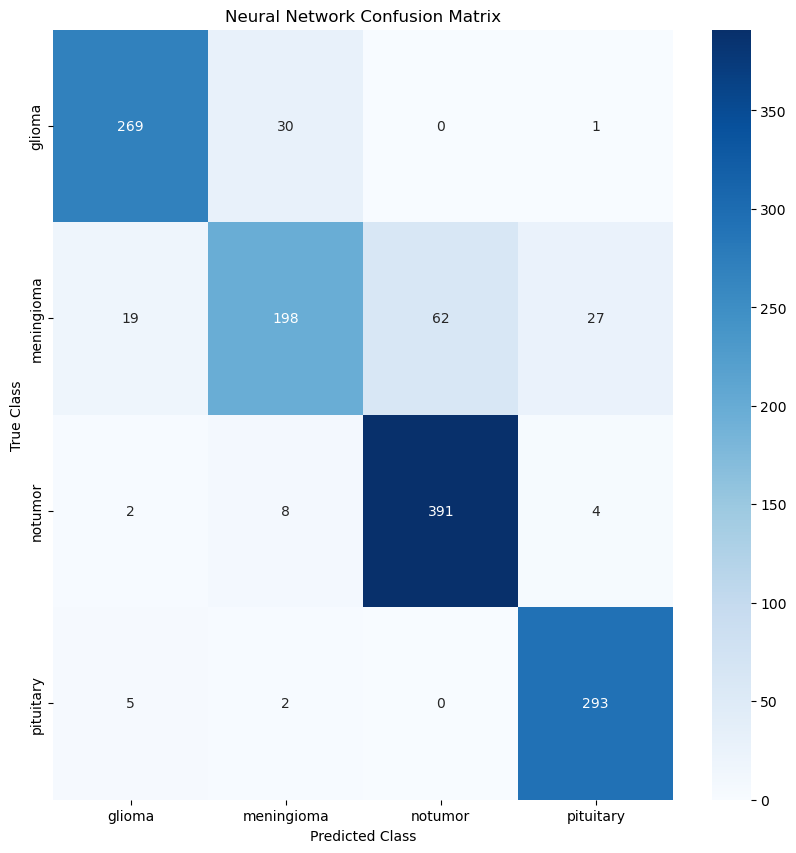

                Accuracy  Precision    Recall  F1 Score
Neural Network  0.877956   0.875791  0.877956  0.872934


In [25]:
# Plot the confusion matrix
m.plot_confusion_matrix(cm, class_paths, 'Neural Network')

# Display the metrics DataFrame
print(neueral_net_df)

## Model 2

In [35]:
# Evaluate the model on the test data
test_loss2, test_accuracy2 = model2.evaluate(test_ds)

41/41 [==============================] - 3s 82ms/step - loss: 1.9822 - accuracy: 0.8528


In [36]:
# Get the predicted classes
y_pred2 = model2.predict(test_ds)
predicted_classes2 = np.argmax(y_pred2, axis=1)

41/41 [==============================] - 3s 76ms/step


In [37]:
# Calculate metrics
regularization_df = calculate_metrics(true_classes, predicted_classes2, 'Neural Network: regularization')

In [38]:
regularization_df

,Accuracy,Precision,Recall,F1 Score
Neural Network: regularization,0.852784,0.849916,0.852784,0.844704


In [39]:
cm = confusion_matrix(true_classes, predicted_classes2)

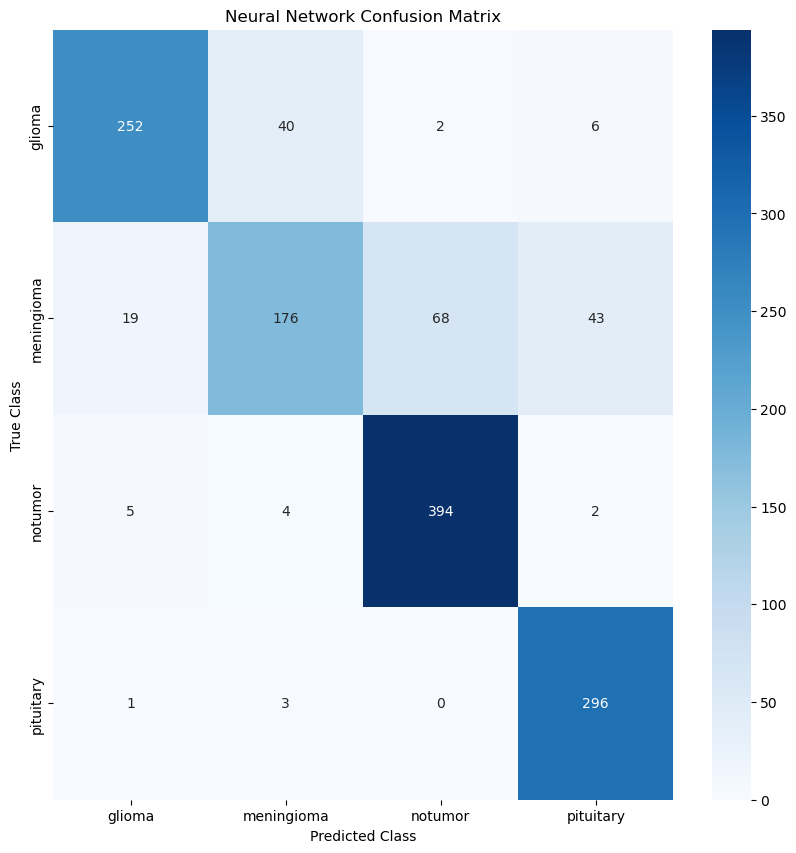

                                Accuracy  Precision    Recall  F1 Score
Neural Network: regularization  0.852784   0.849916  0.852784  0.844704


In [40]:
# Plot the confusion matrix
m.plot_confusion_matrix(cm, class_paths, 'Neural Network')

# Display the metrics DataFrame
print(regularization_df)

In [41]:
df = pd.read_csv('./scores.csv', index_col=0 )

In [42]:
df

,Accuracy,Precision,Recall,F1 Score
Model,,,,
baseline,0.46987,0.468308,0.46987,0.463567


In [43]:
df = pd.concat([df, neueral_net_df, regularization_df], axis = 0 )

In [44]:
df

,Accuracy,Precision,Recall,F1 Score
baseline,0.469870,0.468308,0.469870,0.463567
Neural Network,0.877956,0.875791,0.877956,0.872934
Neural Network: regularization,0.852784,0.849916,0.852784,0.844704


In [45]:
df.to_csv('./scores.csv')